In [165]:
import pandas as pd
import numpy as np
import scipy.stats
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from scipy import spatial
import matplotlib.patches as mpatches
from matplotlib import transforms
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.datasets import make_biclusters
from sklearn.cluster import SpectralCoclustering
from sklearn.metrics import consensus_score
from sklearn.cluster import KMeans
import sys
import sklearn
import sklearn.preprocessing
import os
import glob
import scipy.stats as st
import re
import time
import datetime
import sqlite3
!pip install surprise
!pip install prepro
from surprise import accuracy
from surprise.reader import Reader
from surprise.dataset import Dataset
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms.knns import KNNBasic
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.model_selection import KFold
from surprise import CoClustering

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [166]:
df = pd.read_csv('/content/drive/MyDrive/Cluster-Based-RS/SpotifyFeatures.csv')

In [167]:
df.columns

Index(['genre', 'artist_name', 'track_name', 'track_id', 'popularity',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence'],
      dtype='object')

In [168]:
df.describe()

popularity   acousticness   danceability   duration_ms  \
count  232725.000000  232725.000000  232725.000000  2.327250e+05   
mean       41.127502       0.368560       0.554364  2.351223e+05   
std        18.189948       0.354768       0.185608  1.189359e+05   
min         0.000000       0.000000       0.056900  1.538700e+04   
25%        29.000000       0.037600       0.435000  1.828570e+05   
50%        43.000000       0.232000       0.571000  2.204270e+05   
75%        55.000000       0.722000       0.692000  2.657680e+05   
max       100.000000       0.996000       0.989000  5.552917e+06   

              energy  instrumentalness       liveness       loudness  \
count  232725.000000     232725.000000  232725.000000  232725.000000   
mean        0.570958          0.148301       0.215009      -9.569885   
std         0.263456          0.302768       0.198273       5.998204   
min         0.000020          0.000000       0.009670     -52.457000   
25%         0.385000          0.000000       0.097400     -11.771000   
50%         0.605000          0.000044       0.128000      -7.762000   
75%         0.787000          0.035800       0.264000      -5.501000   
max         0.999000          0.999000       1.000000       3.744000   

         speechiness          tempo        valence  
count  232725.000000  232725.000000  232725.000000  
mean        0.120765     117.666585       0.454917  
std         0.185518      30.898907       0.260065  
min         0.022200      30.379000       0.000000  
25%         0.036700      92.959000       0.237000  
50%         0.050100     115.778000       0.444000  
75%         0.105000     139.054000       0.660000  
max         0.967000     242.903000       1.000000

In [169]:
print('The df database has', df['genre'].nunique(), 'music genres')
# Number of songs
print('The df database has', df['artist_name'].nunique(), 'artists')
# Number of Artists
print('The df database has', df['track_name'].nunique(), 'unique songs')


The df database has 27 music genres
The df database has 14564 artists
The df database has 148615 unique songs


In [170]:
sns.set(context="notebook", palette="Spectral", style = 'darkgrid' ,font_scale = 1.5, color_codes=True)

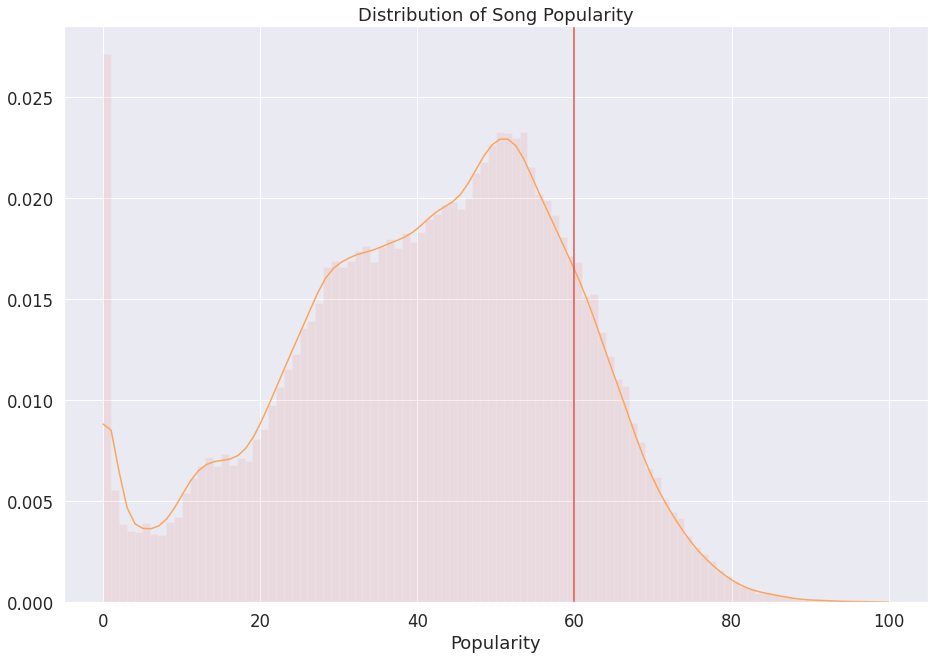

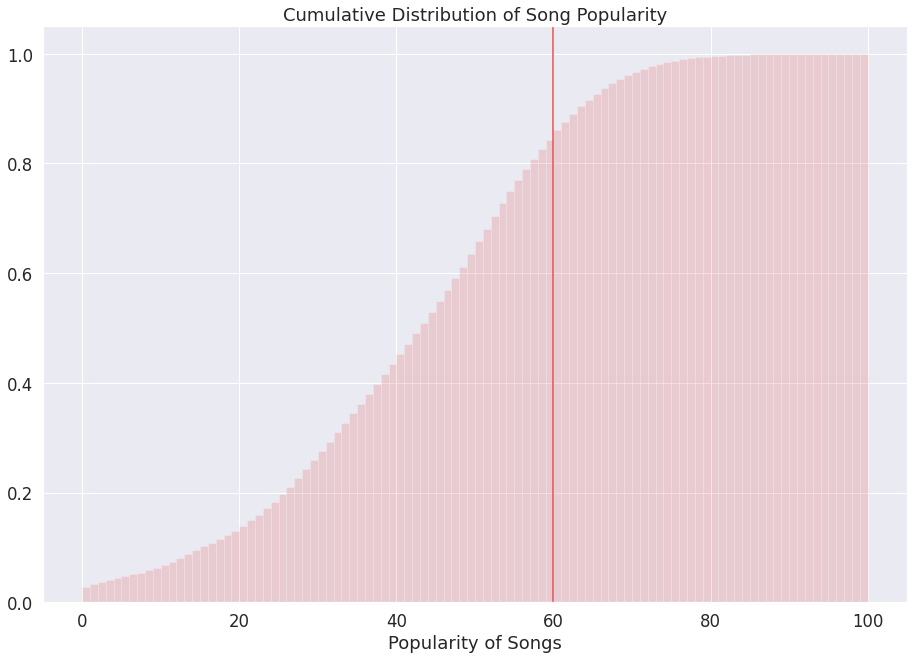

In [171]:
# Since it's more useful to first filter the most popular songs, to enhance the 
# algorithm relevance for engaging users, first we need to find the values for
# the most popular songs and also make the suggestions faster and better
data = df.loc[:, 'popularity'].values
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

kde_xs = np.linspace(min(data), max(data), 100)
kde = st.gaussian_kde(data)

ax.hist(
    data,
    alpha=0.1,
    bins=100,
    density=True
)
ax.plot(
    kde_xs, 
    kde.pdf(kde_xs)
)

ax.axvline(x=60)

plt.xlabel('Popularity')
plt.title('Distribution of Song Popularity')
plt.show()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.hist(
    data,
    alpha=0.2,
    bins=100,
    density=True,
    cumulative=True
)
ax.axvline(x=60)

plt.xlabel('Popularity of Songs')
plt.title('Cumulative Distribution of Song Popularity')
plt.show()

In [172]:
# As we can see, songs with a popularity index of 60 or more are going to fit better
# the suggestion model, thus, let's make the acotation for the main df:
df = df.loc[df.loc[:, 'popularity']>= 60, :]
df.describe()
# Now, comparing to the initial "describe" function from the original df database,
# We can see that all of the values have moved towards the 75% percentile of the
# table; meaning, we are going to be building a recommendation system
# with very popular songs, increasing the likelihood of users liking the song rather
# than disliking it

popularity  acousticness  danceability   duration_ms        energy  \
count  36454.000000  36454.000000  36454.000000  3.645400e+04  36454.000000   
mean      66.427498      0.227710      0.630130  2.255641e+05      0.640634   
std        5.783823      0.259139      0.150644  5.502268e+04      0.193321   
min       60.000000      0.000002      0.061700  3.166700e+04      0.001440   
25%       62.000000      0.025500      0.529000  1.923330e+05      0.513000   
50%       65.000000      0.118000      0.640000  2.185730e+05      0.659000   
75%       69.000000      0.352750      0.741000  2.503730e+05      0.790000   
max      100.000000      0.996000      0.978000  1.025280e+06      0.999000   

       instrumentalness      liveness      loudness   speechiness  \
count      36454.000000  36454.000000  36454.000000  36454.000000   
mean           0.030317      0.180789     -6.930294      0.107316   
std            0.130571      0.141000      3.172416      0.106434   
min            0.000000      0.015700    -41.808000      0.022400   
25%            0.000000      0.095800     -8.294000      0.037400   
50%            0.000002      0.123000     -6.314000      0.057400   
75%            0.000274      0.222000     -4.860250      0.135000   
max            0.985000      0.985000      1.342000      0.922000   

              tempo       valence  
count  36454.000000  36454.000000  
mean     120.486763      0.487068  
std       29.075367      0.228484  
min       39.497000      0.027700  
25%       96.931000      0.307000  
50%      119.935500      0.478000  
75%      140.005000      0.660000  
max      216.115000      0.985000

In [173]:
df.shape
# Our final database for very popular songs consists of 36,454 songs

(36454, 18)

0 popularity
1 acousticness
2 danceability
3 duration_ms
4 energy
5 instrumentalness
6 liveness
7 loudness
8 speechiness
9 tempo
10 valence
11 pca_1
12 pca_2


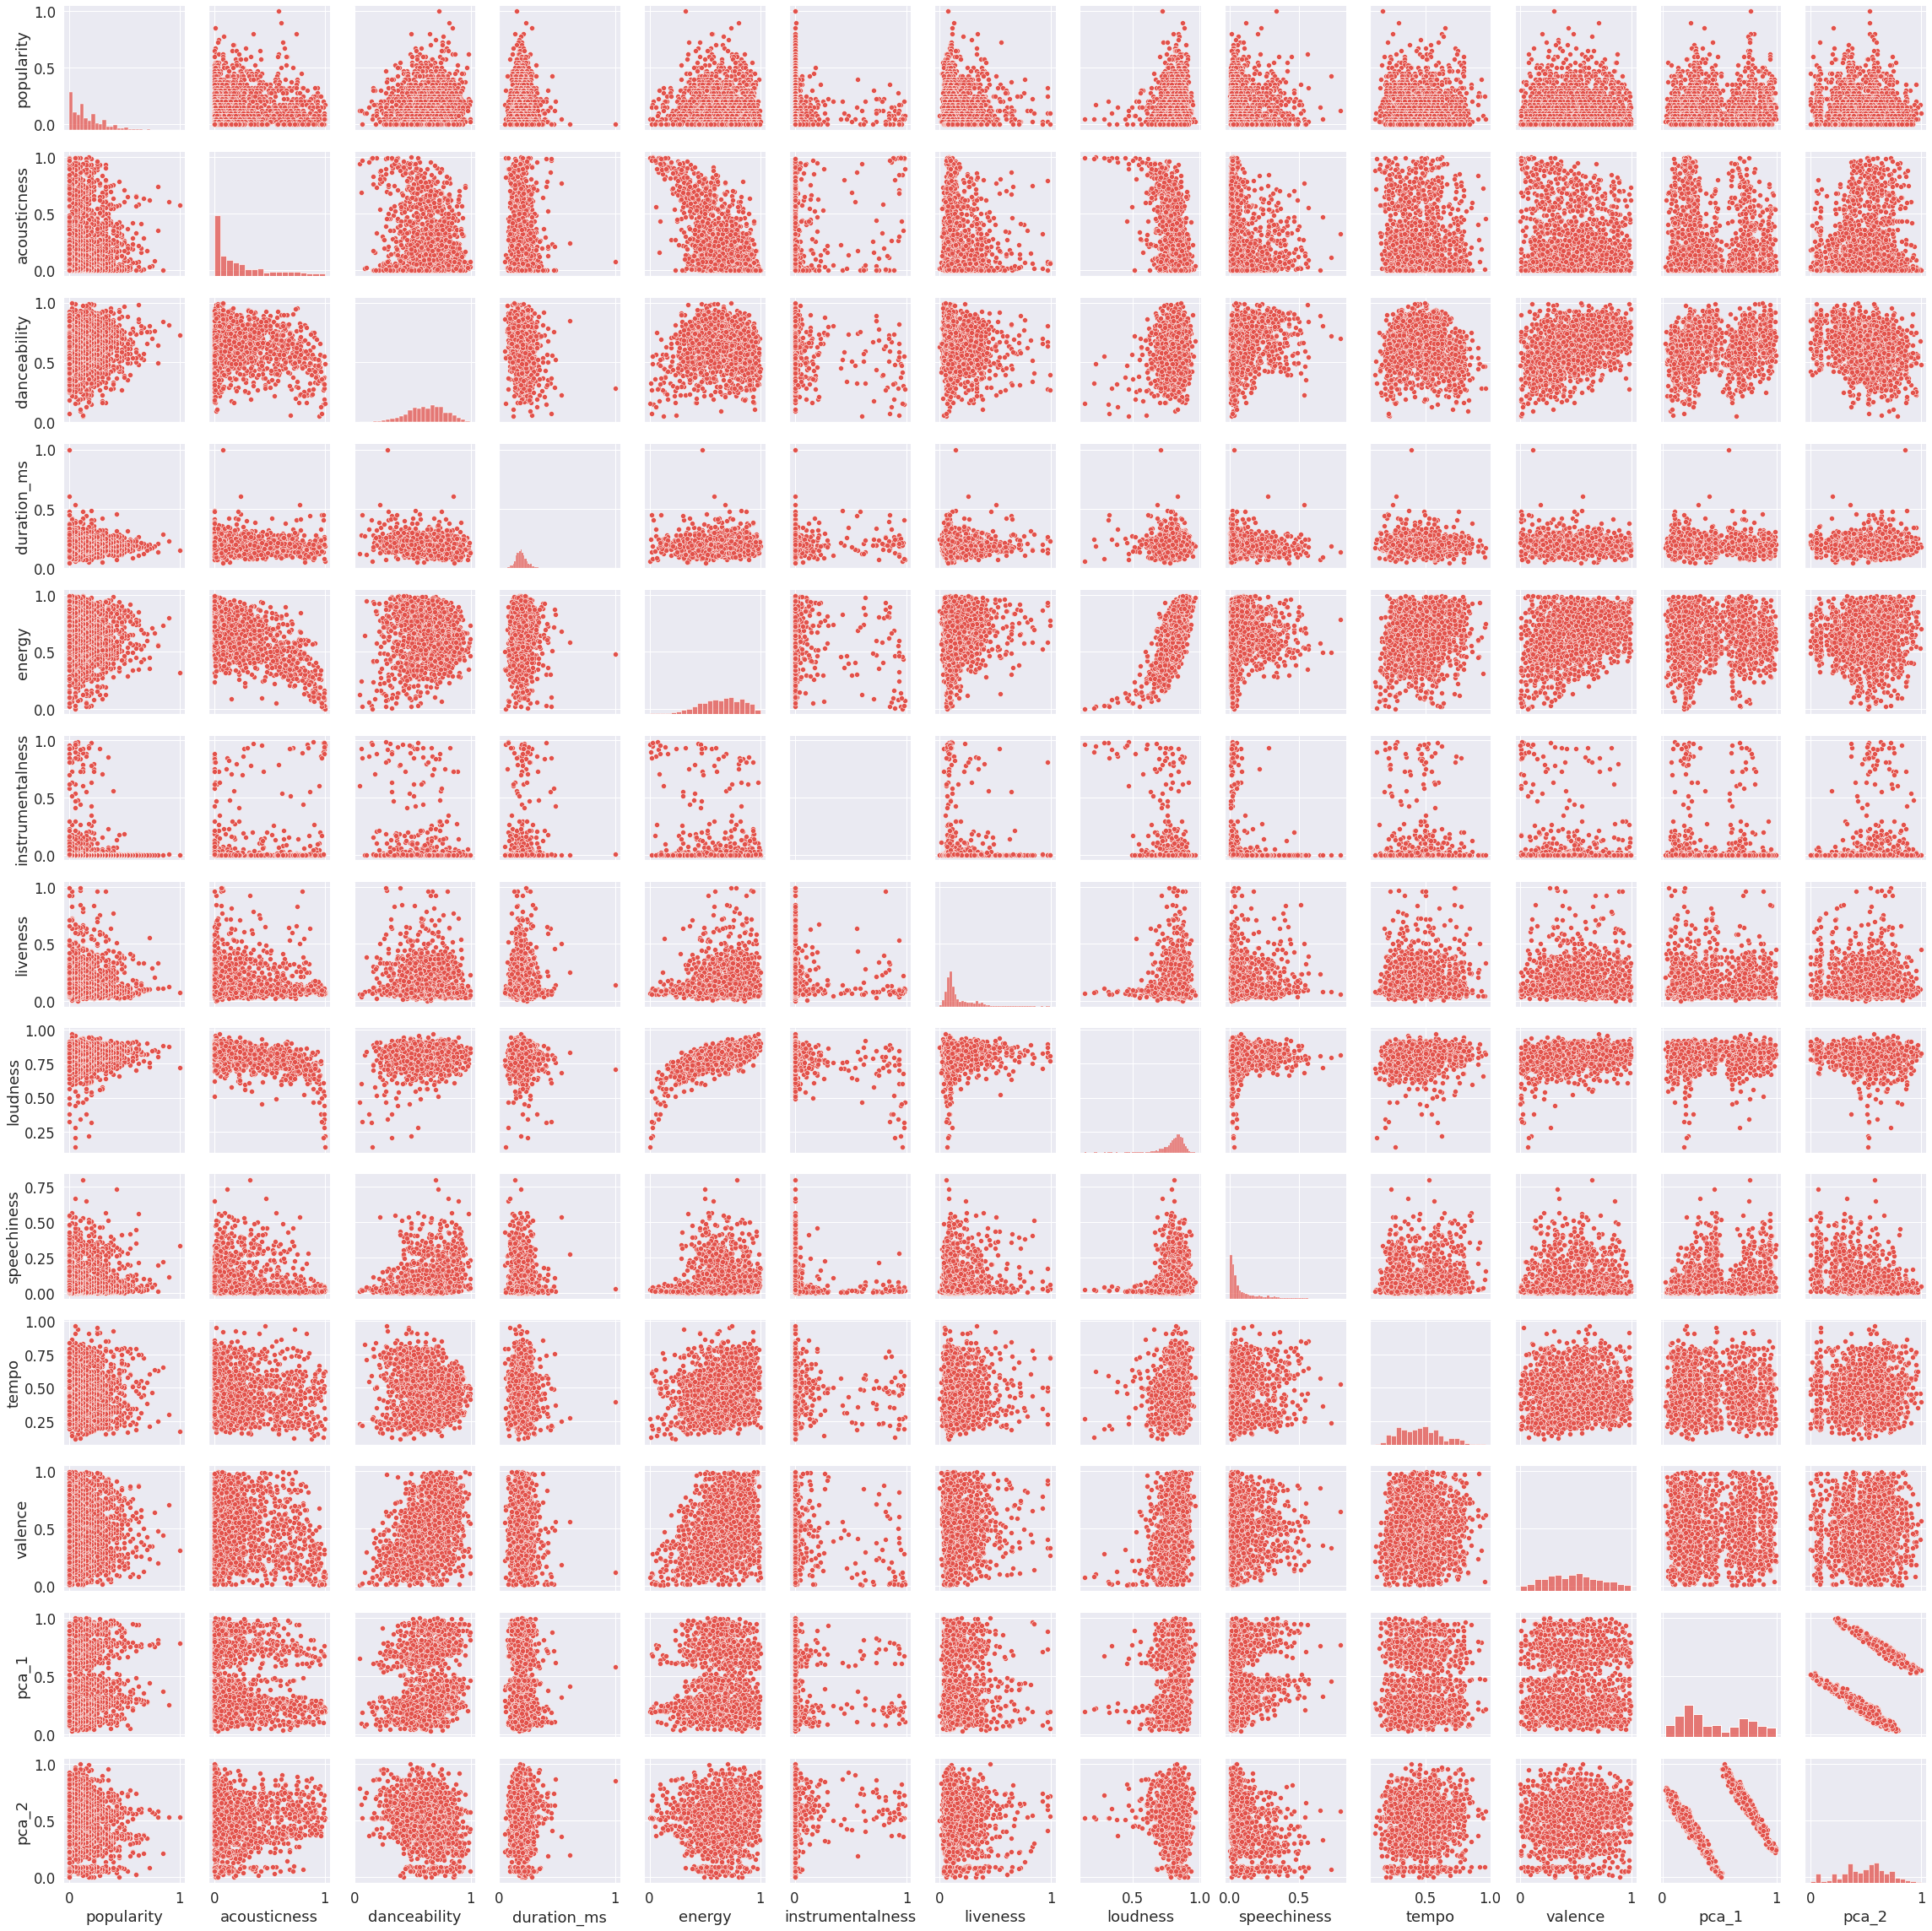

In [174]:
from sklearn.decomposition import PCA
import seaborn as sns

num_components = 2
cols = ['artist_name','track_name','track_id']

def prepro(df, cols, num_components):

    dummies = pd.get_dummies(df.loc[:, ~df.columns.isin(cols)])
    
    merged = pd.merge(df.loc[:, cols], dummies, left_index=True, right_index=True)
    
    merged = merged.groupby(cols).max()
    
    genres = merged.loc[:, [i for i in merged.columns if i.startswith('genre')]]
            
    x = merged.iloc[:, 11:]

    pca = PCA(n_components=num_components)
    x_pca = pca.fit_transform(x)
    
    merged = merged.iloc[:, :11]
    
    for i in range(num_components):
        merged.loc[:, f'pca_{i+1}'] = x_pca[:, i]
        
    for col in merged.columns:
        mn, mx = min(merged.loc[:, col]), max(merged.loc[:, col])
        
        merged.loc[:, col] -= mn
        merged.loc[:, col] /= (mx - mn)

    
    return merged, genres
    
    
tmp, genres = prepro(df, cols, num_components)

tmp = tmp.sort_values(['popularity'], ascending=False)

for i, col in enumerate(tmp.columns):
    print(i, col)

    
sns.pairplot(tmp.iloc[::10,:])
plt.show()

In [175]:
# The key takeaways for the graphs above, are as following:
# We can note that danceability is strongly linked to popularity, meaning
# that the more danceable a song is, the more chances it has of becoming popular
# For popularity and Loudness, we can see that there's a strong correlation between
# the more loudness index and the more popular a song is, it's also related to how
# danceable a song is
# The relation between enery and loudness is also very strong, as it's natural
# for energetic songs to be danceable and, by this, more popular
# Tempo for popularity stays stronger in correlation at the sides, meaning that
# people prefer either very fast-tempo-ed songs or slow-tempoed songs, probably
# because average-tempo-ed songs don't fit exactly into "sad" songs nor "danceable"
# songs, it's interesting as it shows user's very clear preference for songs that
# aren't between the sad-to-happy music (like adele vs drake) and having maybe songs
# from bands that play different genres (like alternative rock)

In [176]:
# Let's keep 10,000 as the database for our song database
for i in range(10000):
    print(i, tmp.iloc[i, :].name)

Streaming output truncated to the last 5000 lines.
5000 ('Halsey', 'New Americana', '6Xs7OKt6i0Ddq8B4M5Dgvr')
5001 ('David Guetta', 'Say My Name (feat. Bebe Rexha & J Balvin) - Lucas & Steve Remix', '3TjLsDgL0bTbSQIF6M5Ki8')
5002 ('6ix9ine', 'RONDO', '3p6JF5nt0bZOSgZRONNZp0')
5003 ('6ix9ine', 'DUMMY (feat. TrifeDrew)', '3uPuEFKEzGTn628CCQZUCF')
5004 ('System Of A Down', 'Hypnotize', '6oO7WMjD6kEvCITLbVj0mu')
5005 ('Declan McKenna', 'Brazil', '4sNG6zQBmtq7M8aeeKJRMQ')
5006 ('Justin Timberlake', 'Suit & Tie', '6vt0I1cw1YmAIKDJvHVIM5')
5007 ('Radical Face', 'Welcome Home, Son', '6HTVZeVQ9J6Uiq6tHESxU9')
5008 ('112', 'Peaches and Cream', '2SLZ2rX5773RS16mcqBxG7')
5009 ('grandson', 'Despicable', '5IPT4Noqvo7bsfbWUOHcG4')
5010 ('Machine Gun Kelly', 'Till I Die', '7rq7HvZrCie7MmiGm8pUVC')
5011 ('Maisie Peters', 'Feels Like This', '53Wsf11ElpPr1WAGtRQlcx')
5012 ('Dennis Lloyd', 'Leftovers', '0dcuGoAIPAT7OrP5CGSVBA')
5013 ('Stone Temple Pilots', 'Plush - Acoustic', '3ftHrCjsTUPLgI48m67byk')
501

k=1
k=2
k=3
k=4
k=5
k=6
k=7
k=8
k=9
k=10
k=11
k=12
k=13
k=14
k=15
k=16
k=17
k=18
k=19
k=20
k=21
k=22
k=23
k=24
k=25
k=26
k=27
k=28
k=29
k=30


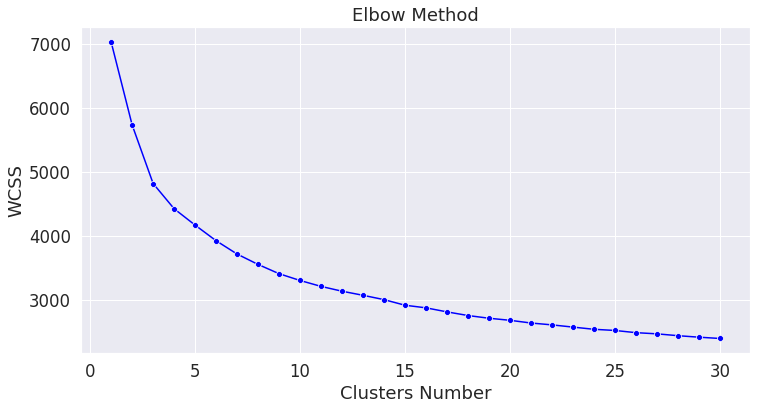

In [177]:
num_clust = 30

wcss = []

for i in range(1, num_clust+1):
    print(f'k={i}')
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 1)
    kmeans.fit(tmp)
    # inertia method returns wcss for that model
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(12,6))

sns.lineplot(range(1, num_clust+1), wcss,marker='o',color='blue')

plt.title('Elbow Method')
plt.xlabel('Clusters Number')
plt.ylabel('WCSS')
plt.show()

In [178]:
# For k = 15, there's a good chance of being the optimal number of clusters, hence

Text(0.5, 1.0, 'Cluster Distribution')

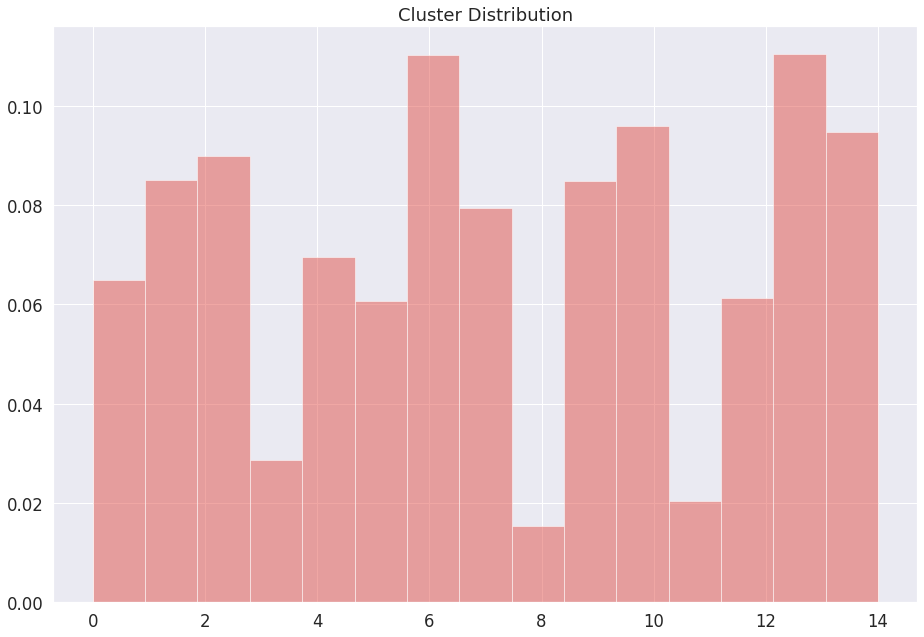

In [179]:
num_clust = 15

kmeans = KMeans(n_clusters = num_clust, init = 'k-means++', random_state = 1)
y_kmeans = kmeans.fit_predict(tmp)

tmp.loc[:, 'cluster'] = y_kmeans

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.hist(
    y_kmeans,
    bins=num_clust,
    density=True,
    alpha=0.5
)

plt.title('Cluster Distribution')


In [180]:
col_nums = {}

for i, c in enumerate(tmp.columns[:-1]):
    col_nums[c] = i
    
col_nums

{'popularity': 0,
 'acousticness': 1,
 'danceability': 2,
 'duration_ms': 3,
 'energy': 4,
 'instrumentalness': 5,
 'liveness': 6,
 'loudness': 7,
 'speechiness': 8,
 'tempo': 9,
 'valence': 10,
 'pca_1': 11,
 'pca_2': 12}

Zedd - The Middle
most similar songs:
    Zedd - The Middle
    Ariana Grande - thank u, next
    Selena Gomez - Back To You - From 13 Reasons Why – Season 2 Soundtrack
    SHAUN - Way Back Home (feat. Conor Maynard) - Sam Feldt Edit
    Dua Lipa - IDGAF
    Kris Kross Amsterdam - Whenever (feat. Conor Maynard)
    Ariana Grande - make up
    Rudimental - These Days (feat. Jess Glynne, Macklemore & Dan Caplen)
    Travis Scott - goosebumps
    Manuel Turizo - Esclavo de Tus Besos


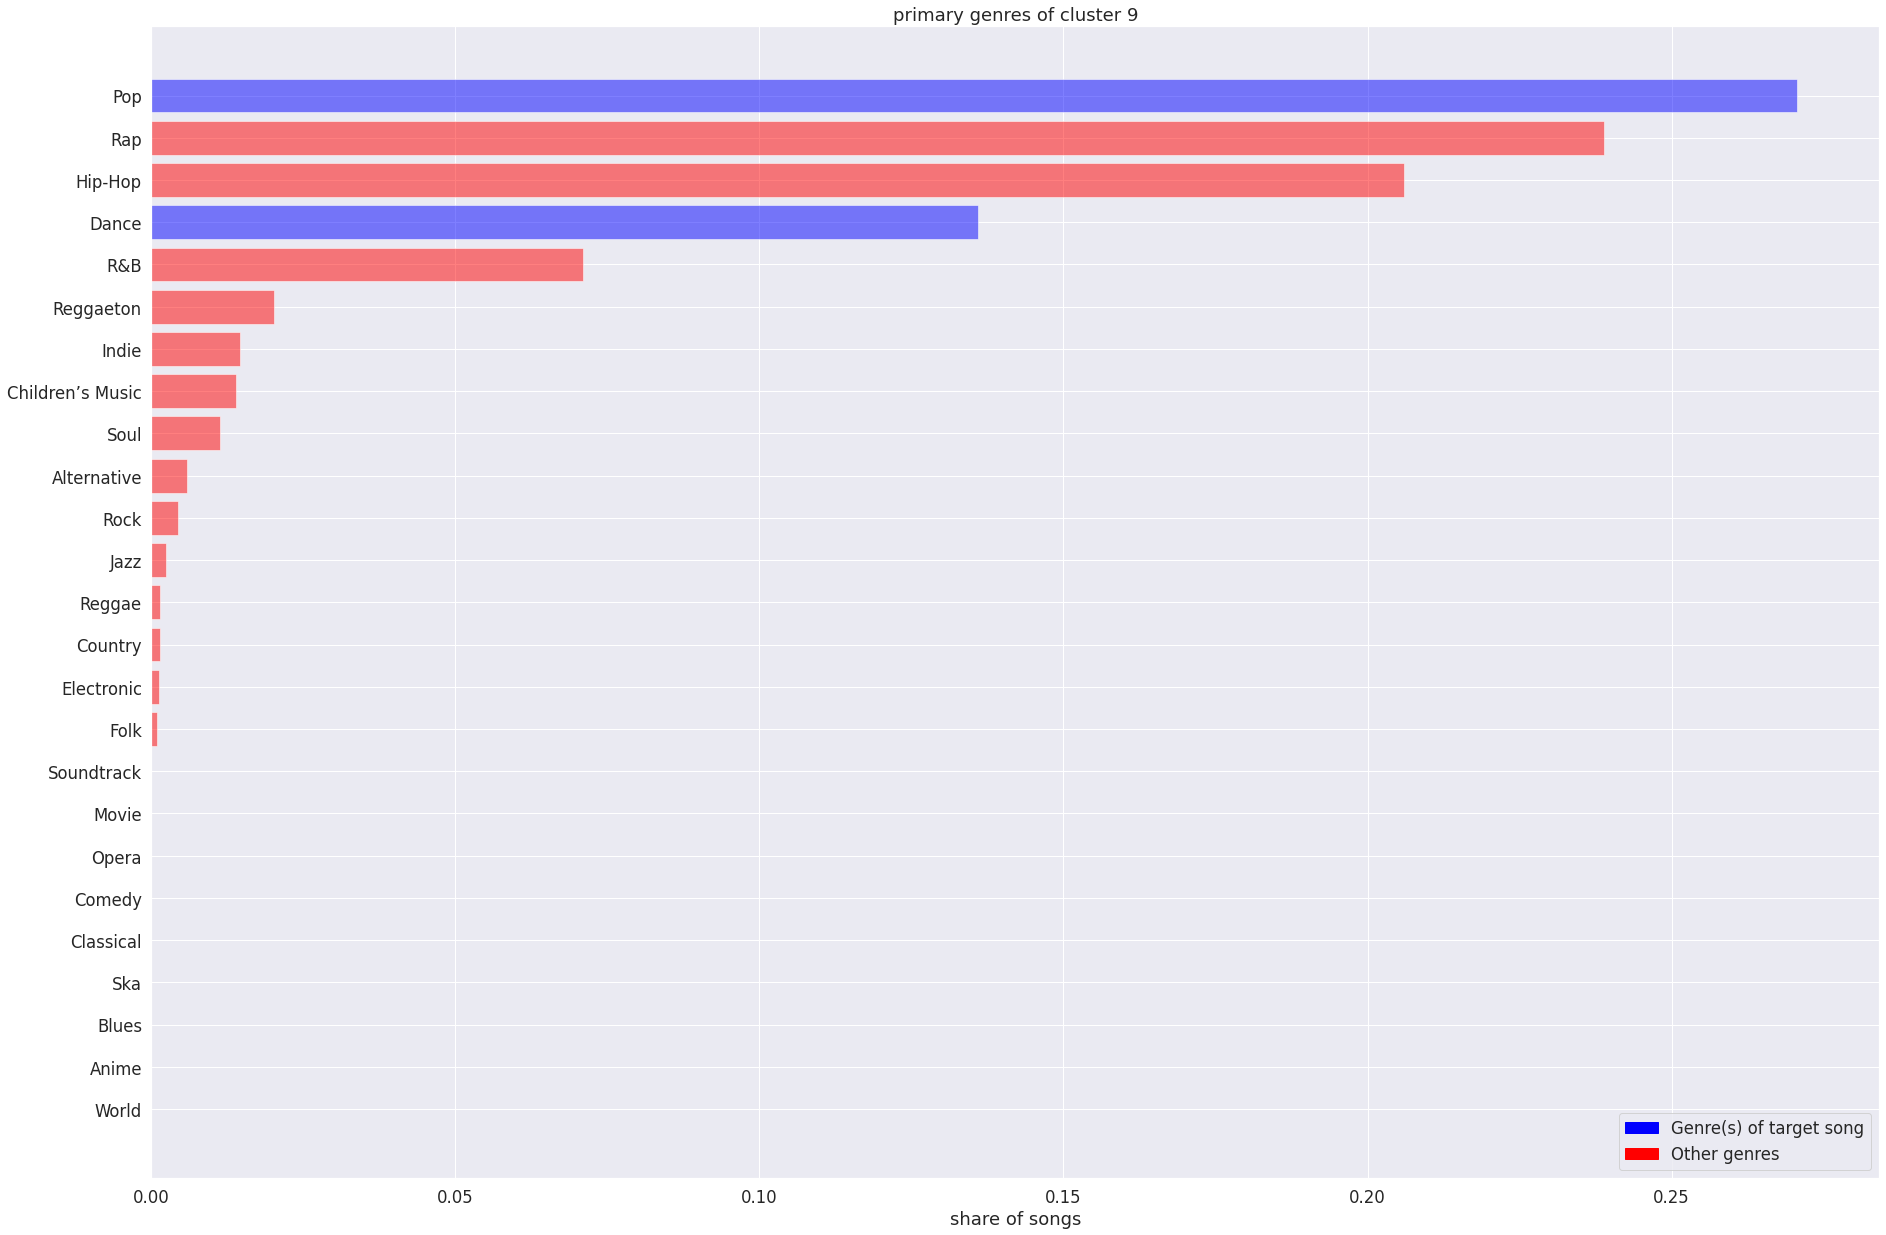

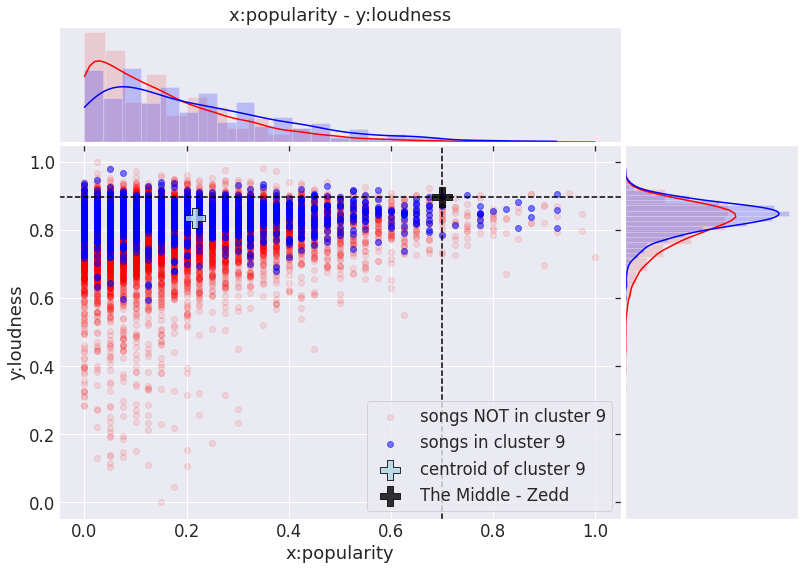

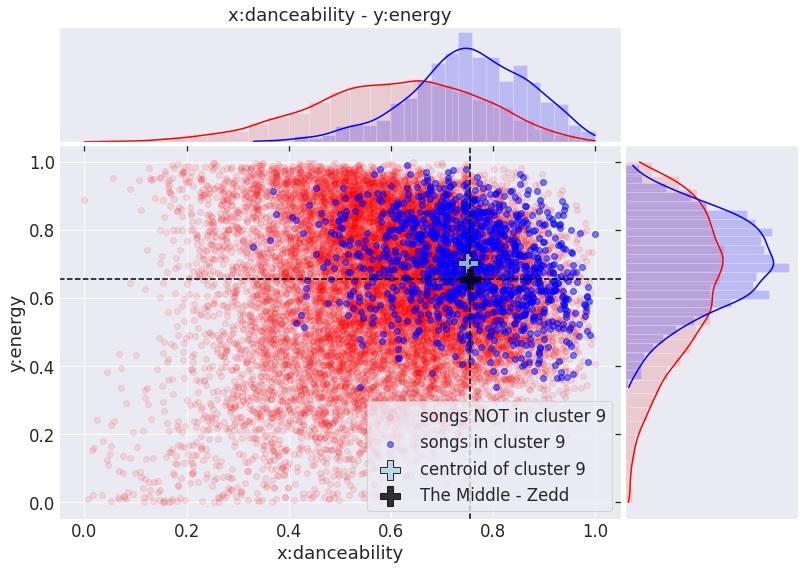

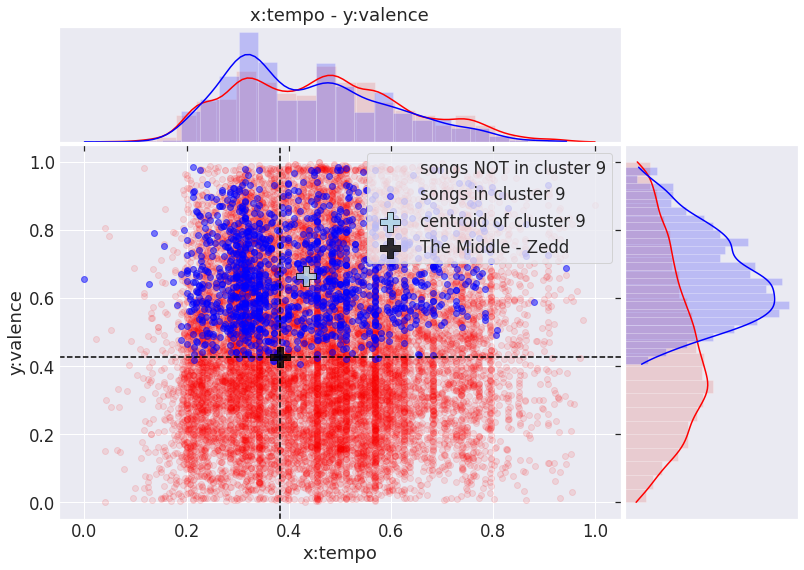

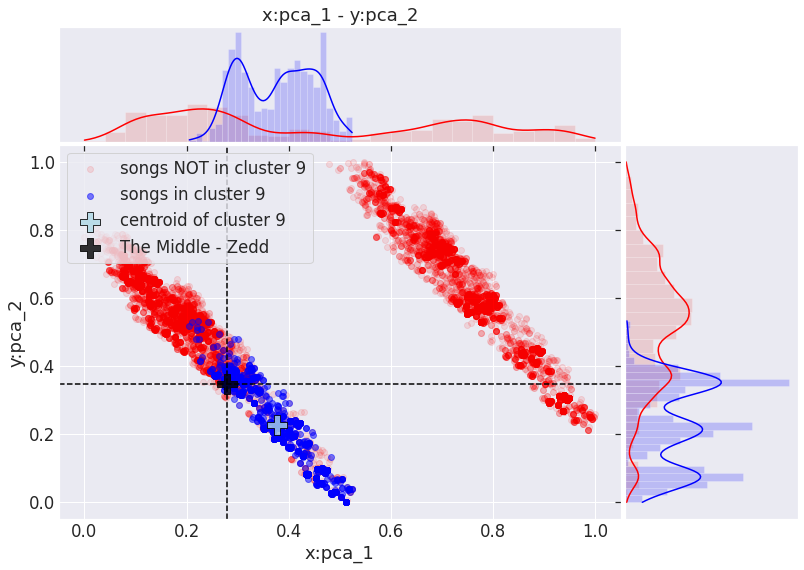

In [181]:
# Let's choose a random song from the 10,000 listed above. I'll try with
# Song No. 100 (and then I'll try with a song I like so I can check if these
# are cool recommendations or not)
from scipy import spatial
import matplotlib.patches as mpatches
from matplotlib import transforms


inds = {
    'index': 100
}

for i in inds.values():
    print(f'{tmp.iloc[i, :].name[0]} - {tmp.iloc[i, :].name[1]}')
    
pairs = [
    ['popularity', 'loudness'],
    ['danceability', 'energy'],
    ['tempo', 'valence'],
    ['pca_1', 'pca_2']
]

    
def charts(inds, tmp, genres):
    
    plotDf = tmp
        
    target_ind = inds['index']
    target_vals = tmp.iloc[target_ind, :]
    
    genres = genres.reindex(tmp.index)
    
    tmp_genres = genres.iloc[target_ind, :]
    
    genres.loc[:, 'cluster'] = tmp.loc[:, 'cluster']

    clust = tmp['cluster'].iloc[target_ind]
    tmp = tmp.loc[tmp.loc[:, 'cluster'] == clust, :]
    
    tmp.loc[:, 'index'] = 0

    for i in range(len(tmp)):
        tmp.loc[:, 'index'].iloc[i] = spatial.distance.cosine(target_vals, tmp.iloc[i, :-1])

    print('most similar songs:')
    head = tmp.sort_values(['index']).head(10)
    
    for i in head.index:
        print(f'    {i[0]} - {i[1]}')
                
    genres = genres.loc[genres.loc[:,'cluster']==clust,:].groupby(['cluster']).sum()
    
    genres = genres.T
    
    genres.loc[:, 'target'] = tmp_genres.T
    
    genres.columns = ['cluster', 'target']
    
    genres = genres.sort_values(['cluster'], ascending = True)
    
    genres.loc[:, 'cluster'] /= genres.loc[:, 'cluster'].sum()
    
    fig = plt.figure()
    ax = fig.add_axes([0,0,2,2])

    ax.barh(
        [i.split('_')[1] for i in genres.index],
        genres.loc[:, 'cluster'],
        color = ['blue' if i == 1 else 'red' for i in genres.loc[:, 'target']],
        alpha = 0.5,
        label=f''
    )

    plt.title(f'primary genres of cluster {clust}')
    plt.xlabel(f'share of songs')
    plt.ylabel(f'')
    
    red_patch = mpatches.Patch(color='red', label=f'Other genres')
    blue_patch = mpatches.Patch(color='blue', label=f'Genre(s) of target song')
    plt.legend(handles=[blue_patch, red_patch], loc='lower right')
    plt.show()


    for p in pairs:
                
        # the random data
        x = plotDf.loc[plotDf.loc[:, 'cluster']!=clust, p[0]]
        y = plotDf.loc[plotDf.loc[:, 'cluster']!=clust, p[1]]
        
        # definitions for the axes
        left, width = 0.1, 0.65
        bottom, height = 0.1, 0.65
        spacing = 0.005


        rect_scatter = [left, bottom, width, height]
        rect_histx = [left, bottom + height + spacing, width, 0.2]
        rect_histy = [left + width + spacing, bottom, 0.2, height]

        # start with a rectangular Figure
        plt.figure(figsize=(12, 8))

        ax_scatter = plt.axes(rect_scatter)
        ax_scatter.tick_params(direction='in', top=True, right=True)
        ax_histx = plt.axes(rect_histx)
        ax_histx.tick_params(direction='in', labelbottom=False)
        ax_histy = plt.axes(rect_histy)
        ax_histy.tick_params(direction='in', labelleft=False)

        # the scatter plot:
        ax_scatter.scatter(x, y,
            color = 'red',
            alpha = 0.1,
            label=f'songs NOT in cluster {clust}'
        )
        
        def get_kde(data):
        
            kde_xs = np.linspace(min(data), max(data), 100)
            kde = st.gaussian_kde(data)
            
            return kde_xs, kde
        
        y_kde_xs, y_kde = get_kde(y)
        x_kde_xs, x_kde = get_kde(x)


        ax_histx.hist(x, 
                      bins=25, 
                      alpha=0.2, 
                      density=True
        )
        ax_histy.hist(y, 
                      bins=25, 
                      alpha=0.2, 
                      density=True, 
                      orientation='horizontal'
        )
        
        base = plt.gca().transData
        rot = transforms.Affine2D().rotate_deg(90)
        
        ax_histx.plot(
            x_kde_xs, 
            x_kde.pdf(x_kde_xs), color='red'
        )
        ax_histy.plot(
            y_kde_xs, 
            -y_kde.pdf(y_kde_xs), color='red', transform = rot + base
        )
        
        x = tmp.loc[tmp.loc[:, 'cluster']==clust, p[0]]
        y = tmp.loc[tmp.loc[:, 'cluster']==clust, p[1]]
        
        ax_scatter.scatter(x, y, 
            color = 'blue',
            alpha = 0.5,
            label=f'songs in cluster {clust}'
        )        
        ax_scatter.scatter(
            kmeans.cluster_centers_[clust, col_nums[p[0]]],
            kmeans.cluster_centers_[clust, col_nums[p[1]]],
            color = 'lightblue',
            edgecolors = 'black',
            alpha = 0.8,
            s=400,
            marker='P',
            label=f'centroid of cluster {clust}'
        )
        ax_scatter.scatter(
            target_vals[col_nums[p[0]]],
            target_vals[col_nums[p[1]]],
            color = 'black',
            alpha = 0.8,
            s=400,
            marker='P',
            label=f'{head.index[0][1]} - {head.index[0][0]}'
        )
        ax_scatter.legend()
                
        ax_scatter.axvline(x=target_vals[col_nums[p[0]]], color='black', linestyle='dashed')
        ax_scatter.axhline(y=target_vals[col_nums[p[1]]], color='black', linestyle='dashed')

        y_kde_xs, y_kde = get_kde(y)
        x_kde_xs, x_kde = get_kde(x)

        ax_histx.hist(x, bins=25, alpha=0.2, density=True, color='blue')
        ax_histy.hist(y, bins=25, alpha=0.2, density=True, color='blue', orientation='horizontal')
        
        ax_histx.plot(
            x_kde_xs, 
            x_kde.pdf(x_kde_xs), color='blue'
        )
        ax_histy.plot(
            y_kde_xs, 
            -y_kde.pdf(y_kde_xs), color='blue', transform = rot + base
        )
        
        ax_histx.axes.xaxis.set_visible(False)
        ax_histx.axes.yaxis.set_visible(False)
        ax_histy.axes.xaxis.set_visible(False)
        ax_histy.axes.yaxis.set_visible(False)
        

        ax_histx.set_title(f'x:{p[0]} - y:{p[1]}')
        ax_scatter.set_xlabel(f'x:{p[0]}')
        ax_scatter.set_ylabel(f'y:{p[1]}')

        plt.show()

    
charts(inds, tmp, genres)

Panic! At The Disco - Hurricane
most similar songs:
    Panic! At The Disco - Hurricane
    The Veronicas - In My Blood
    Panic! At The Disco - Memories
    Parkway Drive - Vice Grip
    The Cab - Angel With A Shotgun
    Papa Roach - Falling Apart
    Purity Ring - Fineshrine
    Trivium - Strife
    Grimes - We Appreciate Power
    QUIX - Giving Up (feat. Jaden Michaels)


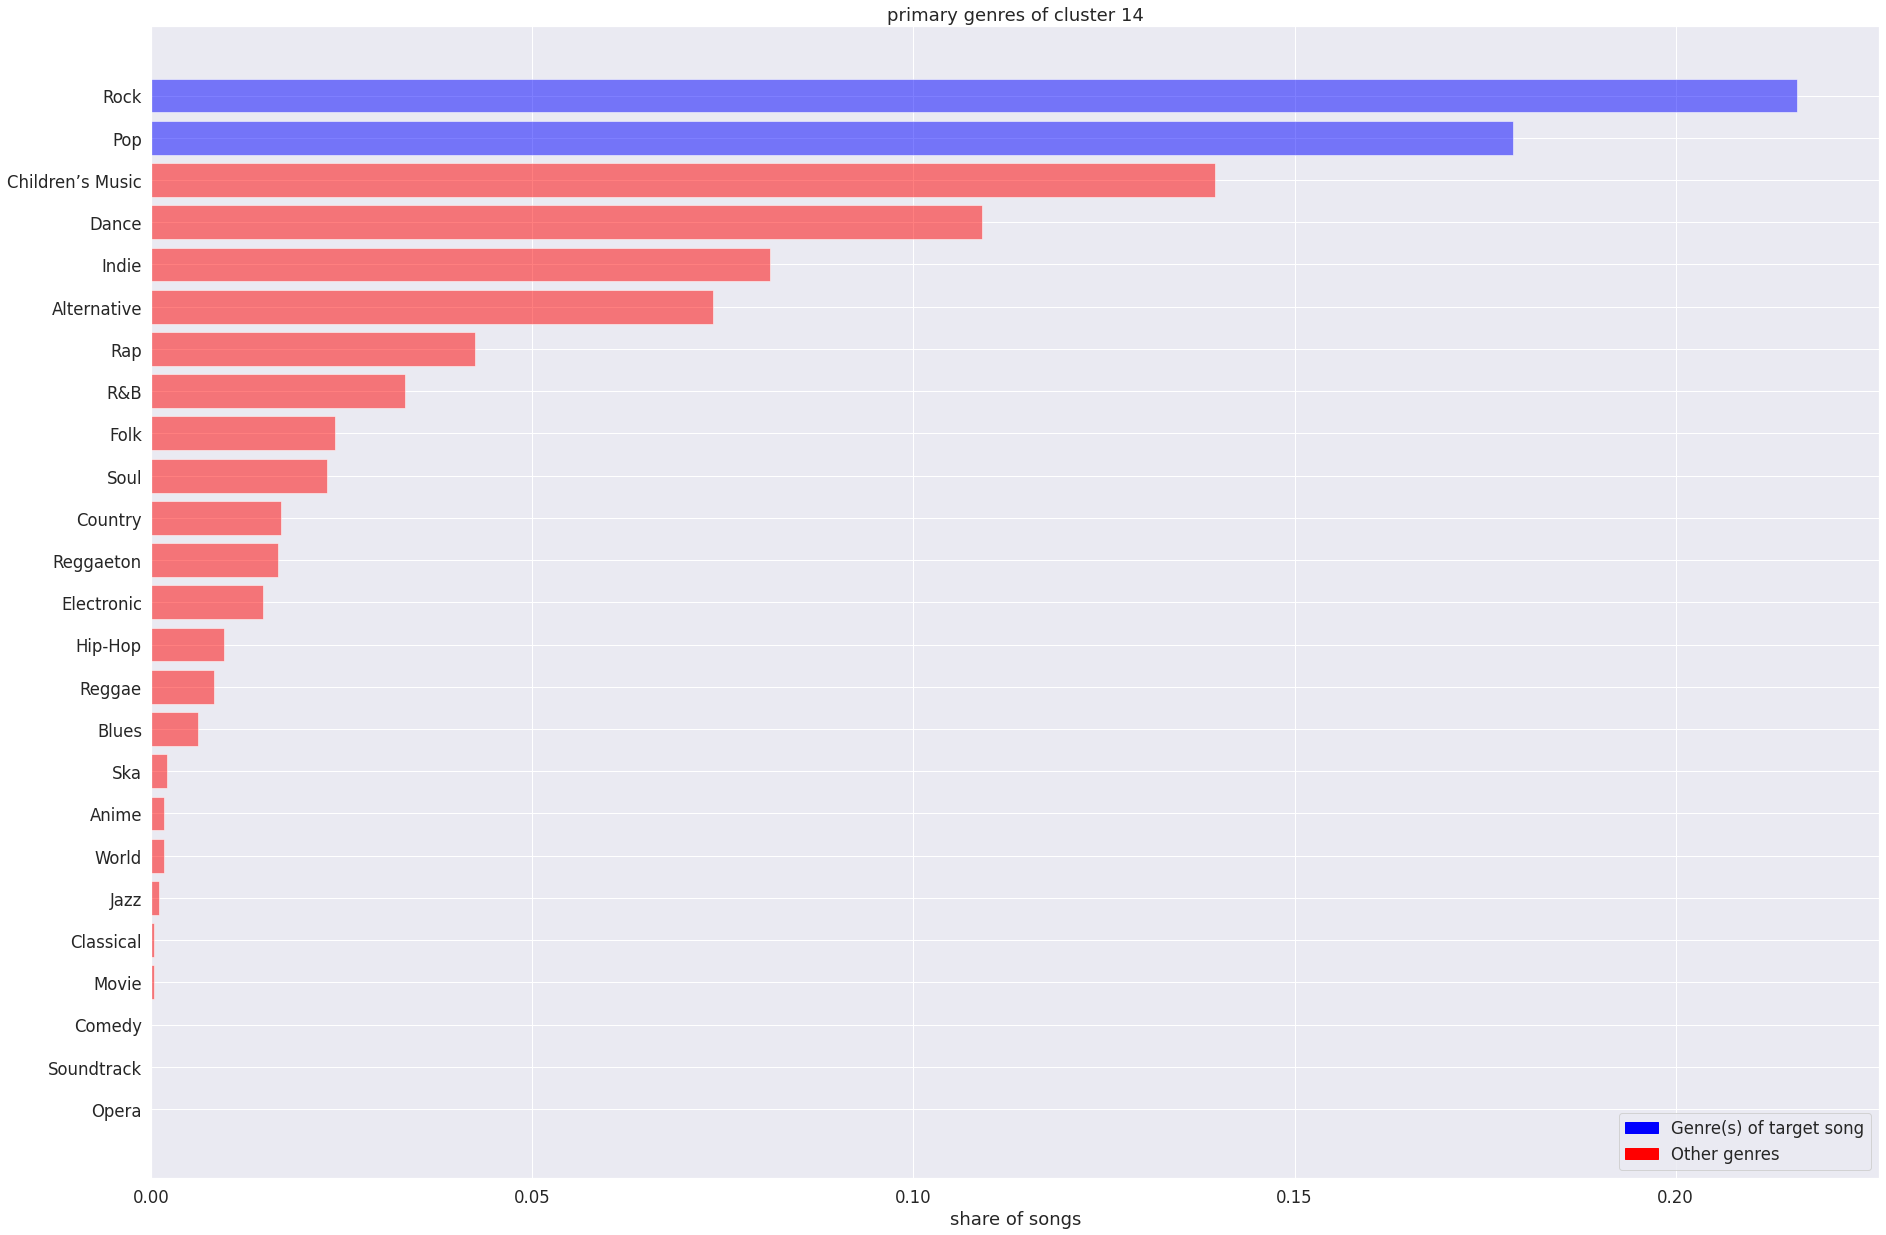

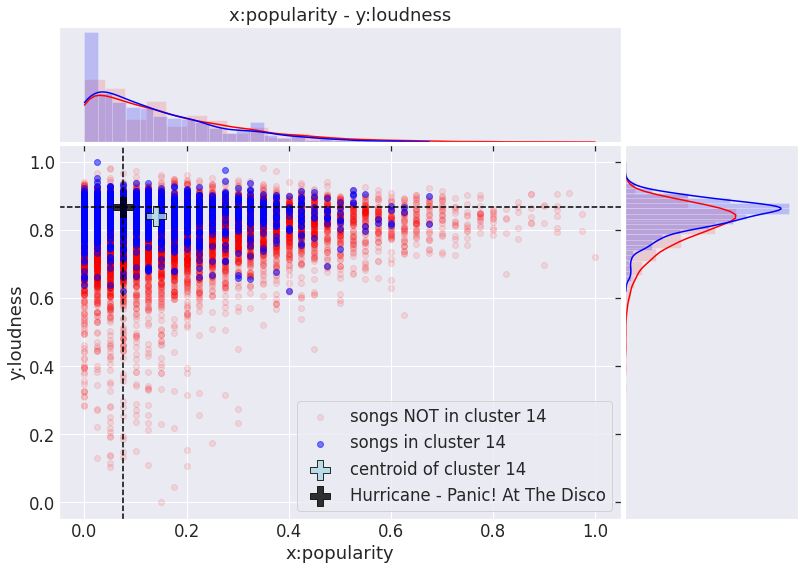

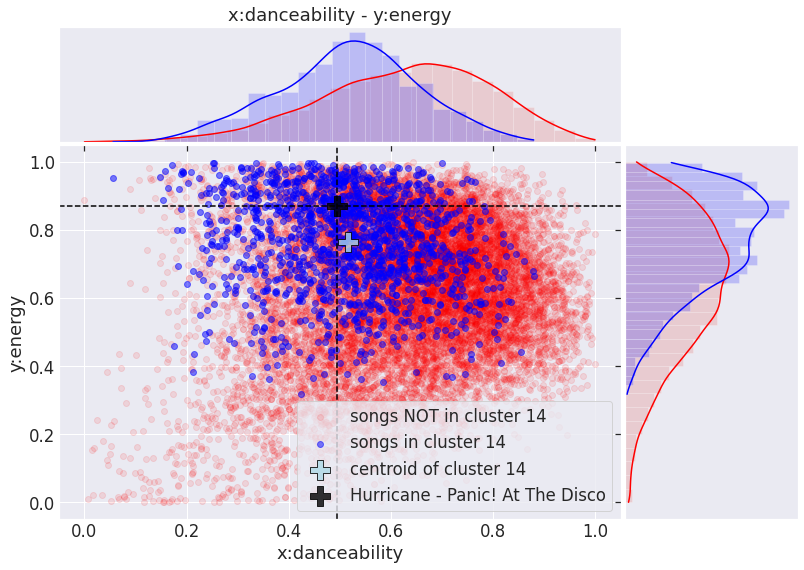

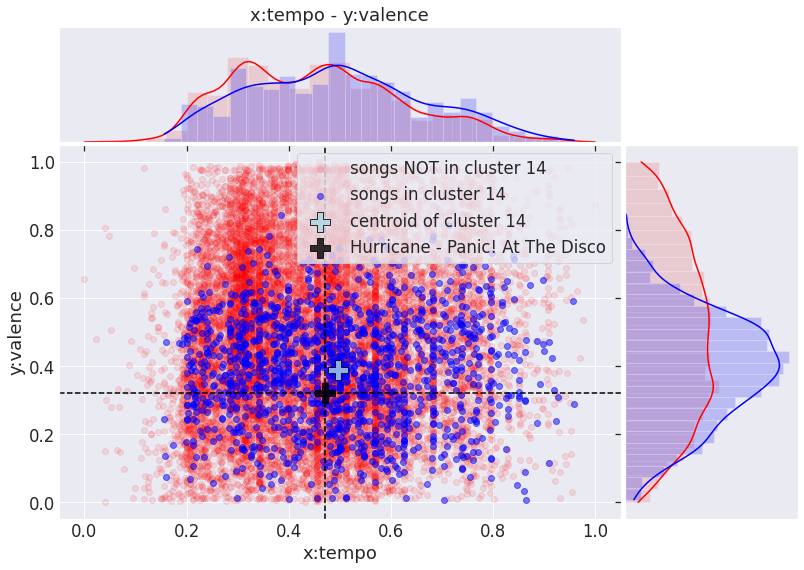

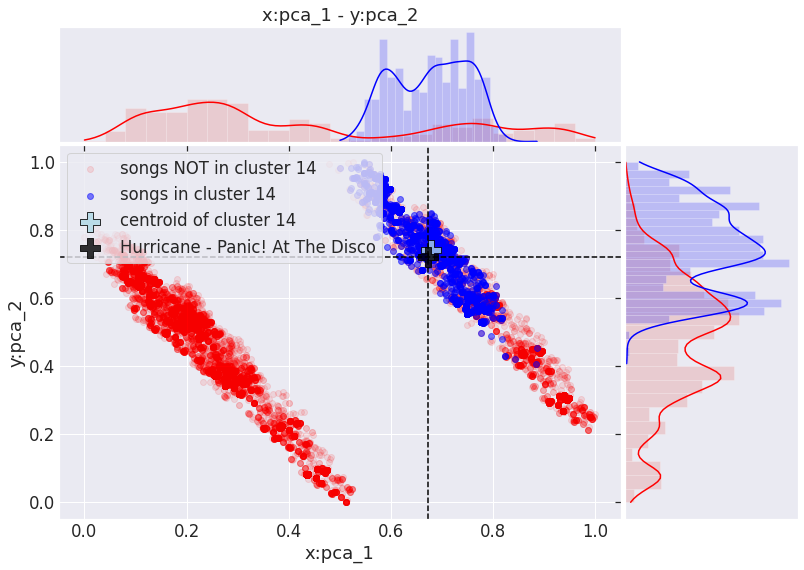

In [182]:
# Finally, as a Panic at the Disco! fan, I chose Song No. 9996 ('Panic! At The Disco', 'Hurricane')
from scipy import spatial
import matplotlib.patches as mpatches
from matplotlib import transforms

# We fill the "index" with the number of our song:
inds = {
    'index': 9996
}

for i in inds.values():
    print(f'{tmp.iloc[i, :].name[0]} - {tmp.iloc[i, :].name[1]}')
    
pairs = [
    ['popularity', 'loudness'],
    ['danceability', 'energy'],
    ['tempo', 'valence'],
    ['pca_1', 'pca_2']
]

    
def charts(inds, tmp, genres):
    
    plotDf = tmp
        
    target_ind = inds['index']
    target_vals = tmp.iloc[target_ind, :]
    
    genres = genres.reindex(tmp.index)
    
    tmp_genres = genres.iloc[target_ind, :]
    
    genres.loc[:, 'cluster'] = tmp.loc[:, 'cluster']

    clust = tmp['cluster'].iloc[target_ind]
    tmp = tmp.loc[tmp.loc[:, 'cluster'] == clust, :]
    
    tmp.loc[:, 'index'] = 0

    for i in range(len(tmp)):
        tmp.loc[:, 'index'].iloc[i] = spatial.distance.cosine(target_vals, tmp.iloc[i, :-1])

    print('most similar songs:')
    head = tmp.sort_values(['index']).head(10)
    
    for i in head.index:
        print(f'    {i[0]} - {i[1]}')
                
    genres = genres.loc[genres.loc[:,'cluster']==clust,:].groupby(['cluster']).sum()
    
    genres = genres.T
    
    genres.loc[:, 'target'] = tmp_genres.T
    
    genres.columns = ['cluster', 'target']
    
    genres = genres.sort_values(['cluster'], ascending = True)
    
    genres.loc[:, 'cluster'] /= genres.loc[:, 'cluster'].sum()
    
    fig = plt.figure()
    ax = fig.add_axes([0,0,2,2])

    ax.barh(
        [i.split('_')[1] for i in genres.index],
        genres.loc[:, 'cluster'],
        color = ['blue' if i == 1 else 'red' for i in genres.loc[:, 'target']],
        alpha = 0.5,
        label=f''
    )

    plt.title(f'primary genres of cluster {clust}')
    plt.xlabel(f'share of songs')
    plt.ylabel(f'')
    
    red_patch = mpatches.Patch(color='red', label=f'Other genres')
    blue_patch = mpatches.Patch(color='blue', label=f'Genre(s) of target song')
    plt.legend(handles=[blue_patch, red_patch], loc='lower right')
    plt.show()


    for p in pairs:
                
        # the random data
        x = plotDf.loc[plotDf.loc[:, 'cluster']!=clust, p[0]]
        y = plotDf.loc[plotDf.loc[:, 'cluster']!=clust, p[1]]
        
        # definitions for the axes
        left, width = 0.1, 0.65
        bottom, height = 0.1, 0.65
        spacing = 0.005


        rect_scatter = [left, bottom, width, height]
        rect_histx = [left, bottom + height + spacing, width, 0.2]
        rect_histy = [left + width + spacing, bottom, 0.2, height]

        # start with a rectangular Figure
        plt.figure(figsize=(12, 8))

        ax_scatter = plt.axes(rect_scatter)
        ax_scatter.tick_params(direction='in', top=True, right=True)
        ax_histx = plt.axes(rect_histx)
        ax_histx.tick_params(direction='in', labelbottom=False)
        ax_histy = plt.axes(rect_histy)
        ax_histy.tick_params(direction='in', labelleft=False)

        # the scatter plot:
        ax_scatter.scatter(x, y,
            color = 'red',
            alpha = 0.1,
            label=f'songs NOT in cluster {clust}'
        )
        
        def get_kde(data):
        
            kde_xs = np.linspace(min(data), max(data), 100)
            kde = st.gaussian_kde(data)
            
            return kde_xs, kde
        
        y_kde_xs, y_kde = get_kde(y)
        x_kde_xs, x_kde = get_kde(x)


        ax_histx.hist(x, 
                      bins=25, 
                      alpha=0.2, 
                      density=True
        )
        ax_histy.hist(y, 
                      bins=25, 
                      alpha=0.2, 
                      density=True, 
                      orientation='horizontal'
        )
        
        base = plt.gca().transData
        rot = transforms.Affine2D().rotate_deg(90)
        
        ax_histx.plot(
            x_kde_xs, 
            x_kde.pdf(x_kde_xs), color='red'
        )
        ax_histy.plot(
            y_kde_xs, 
            -y_kde.pdf(y_kde_xs), color='red', transform = rot + base
        )
        
        x = tmp.loc[tmp.loc[:, 'cluster']==clust, p[0]]
        y = tmp.loc[tmp.loc[:, 'cluster']==clust, p[1]]
        
        ax_scatter.scatter(x, y, 
            color = 'blue',
            alpha = 0.5,
            label=f'songs in cluster {clust}'
        )        
        ax_scatter.scatter(
            kmeans.cluster_centers_[clust, col_nums[p[0]]],
            kmeans.cluster_centers_[clust, col_nums[p[1]]],
            color = 'lightblue',
            edgecolors = 'black',
            alpha = 0.8,
            s=400,
            marker='P',
            label=f'centroid of cluster {clust}'
        )
        ax_scatter.scatter(
            target_vals[col_nums[p[0]]],
            target_vals[col_nums[p[1]]],
            color = 'black',
            alpha = 0.8,
            s=400,
            marker='P',
            label=f'{head.index[0][1]} - {head.index[0][0]}'
        )
        ax_scatter.legend()
                
        ax_scatter.axvline(x=target_vals[col_nums[p[0]]], color='black', linestyle='dashed')
        ax_scatter.axhline(y=target_vals[col_nums[p[1]]], color='black', linestyle='dashed')

        y_kde_xs, y_kde = get_kde(y)
        x_kde_xs, x_kde = get_kde(x)

        ax_histx.hist(x, bins=25, alpha=0.2, density=True, color='blue')
        ax_histy.hist(y, bins=25, alpha=0.2, density=True, color='blue', orientation='horizontal')
        
        ax_histx.plot(
            x_kde_xs, 
            x_kde.pdf(x_kde_xs), color='blue'
        )
        ax_histy.plot(
            y_kde_xs, 
            -y_kde.pdf(y_kde_xs), color='blue', transform = rot + base
        )
        
        ax_histx.axes.xaxis.set_visible(False)
        ax_histx.axes.yaxis.set_visible(False)
        ax_histy.axes.xaxis.set_visible(False)
        ax_histy.axes.yaxis.set_visible(False)
        

        ax_histx.set_title(f'x:{p[0]} - y:{p[1]}')
        ax_scatter.set_xlabel(f'x:{p[0]}')
        ax_scatter.set_ylabel(f'y:{p[1]}')

        plt.show()

    
charts(inds, tmp, genres)